<a href="https://colab.research.google.com/github/arumajirou/-daily-test/blob/main/01_multi_time_series_and_covariates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


日本語


複数の時系列，事前学習済みモデル，共変量
このノートブックは、チュートリアルの役割を果たします。

複数の時系列で1つのモデルをトレーニングする
訓練中に見たことのない時系列の予測を得るために事前訓練されたモデルを使用する
共変量を使ったモデルの訓練と使用
1つまたは複数の多変量解析を使ってモデルをトレーニングし、使用する 時系列
まず、必要なインポートをいくつか紹介します。

DeepL.comで別の訳し方を確認する



下


In [ ]:
!pip install utils
!pip install torch
!pip install darts
!pip install logging
!pip install warnings

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 5.4 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 76.6 MB 1.1 MB/s 
     |████████████████████████████████| 9.4 MB 50.0 MB/s 
     |████████████████████████████████| 1.9 MB 60.0 MB/s 
     |████████████████████████████████| 575 kB 65.1 MB/s 
     |████████████████████████████████| 9.9 MB 53.1 MB/s 
     |████████████████████████████████| 800 kB 82.1 MB/s 
     |████████████████████████████████| 91 kB 8.3 MB/s 
     |████████████████████████████████| 1.6 MB 62.5 MB/s 
     |████████████████████████████████| 295 kB 70.4 MB/s 
     |████████████████████████████████| 965 kB 83.9 MB/s 
     |██████

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 2.5 MB/s 
ERROR: Could not find a version that satisfies the requirement logging (from versions: 0.4.9.6)
ERROR: No matching distribution found for logging
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement warnings (from versions: none)
ERROR: No matching distribution found for warnings


In [ ]:
# fix python path if working locally
# GitHub リポジトリの URL を設定
path ="https://github.com/unit8co/darts/tree/master/examples"
from utils import path #、utilsモジュールからpath関数をインポート
# fix_pythonpath_if_working_locally()

import pandas as pd#pandasライブラリをpdとしてインポート
import numpy as np#numpyライブラリをnpとしてインポート
import torch#torchライブラリをインポート
import matplotlib.pyplot as plt#matplotlibライブラリからpyplotモジュールをplt としてインポート

from darts import TimeSeries#dartsライブラリからTimeSeriesクラスをインポート

#darts.utils.timeseries_generationモジュールから様々な時系列生成関数をインポート
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
#darts.modelsモジュールから様々なモデルをインポート
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    VARIMA,
)
#darts.metricsモジュールから様々なメトリクスをインポート
from darts.metrics import mape, smape, mae
#darts.dataprocessing.transformersモジュールからScalerクラスをインポート
from darts.dataprocessing.transformers import Scaler
#darts.utils.timeseries_generationモジュールからdatetime_attribute_timeseries関数をインポート
from darts.utils.timeseries_generation import datetime_attribute_timeseries
#darts.datasetsモジュールから様々なデータセットをインポート
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset, ElectricityDataset

#ロギングメッセージを無効
import logging
logging.disable(logging.CRITICAL)

#警告メッセージを無視
import warnings
warnings.filterwarnings("ignore")
#matplotlibのプロットをJupyter Notebook内でインライン表示できるようにしたもの
%matplotlib inline

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)


日本語



データを読む
まず、2つの時系列を読んでみましょう。1つは月別の航空旅客数、もう1つは月別の牛一頭あたりの乳生産量です。これらの時系列は、どちらも月次頻度で、顕著な年周性と上昇傾向があり、（完全に偶然ですが）同程度の大きさの値を含んでいること以外は、お互いにあまり関係がありません。

DeepL.comで別の訳し方を確認する



下


In [ ]:
#series_airと series_milkという2つの時系列データセットをプロットしようとしている
series_air = AirPassengersDataset().load()
series_milk = MonthlyMilkDataset().load()

#plot()メソッドはTimeSeriesクラスのメソッドで、時系列データの折れ線グラフを作成するために使用されます。
#labelパラメータで各時系列にラベルを指定し、それを使ってプロットの凡例を作成します。
series_air.plot(label="Number of air passengers")
series_milk.plot(label="Pounds of milk produced per cow")
#プロットに凡例を追加するためにlegend()関数を使用する
plt.legend();

ImportError: ignored

<Figure size 432x288 with 1 Axes>

# 前処理
通常、ニューラルネットワークは正規化/標準化されたデータでより良く動作する傾向があります。ここではScalerクラスを使って、両方の時系列を0と1の間で正規化することにします。

In [ ]:
#データをスケーリングするためのPythonの前処理モジュールであるscikit-learnのScalerクラスのインスタンスを2つ使用している
#最初のインスタンスscaler_air はseries_airデータのフィットと変換に使われ、2 番目のインスタンスscaler_milk はseries_milkデータのフィットと変換に使われます。
scaler_air, scaler_milk = Scaler(), Scaler()
#fit_transformメソッドは、データをスケーリングして、スケーリングされたデータを返します。
series_air_scaled = scaler_air.fit_transform(series_air)
series_milk_scaled = scaler_milk.fit_transform(series_milk)

#データをスケーリングした後、このコードはseries_air_scaledとseries_milk_scaledオブジェクトのplotメソッドを使用してスケーリングされたデータをプロットします。
#label引数はプロットの凡例にデータ系列のラベルを指定するために使用されます。
series_air_scaled.plot(label="air")
series_milk_scaled.plot(label="milk")

#最後に、プロット上に凡例を表示するためにlegendメソッドが呼び出されます。
plt.legend();

ImportError: ignored

<Figure size 432x288 with 1 Axes>

# トレーニング/バリデーションの分割
両シリーズの過去36ヶ月を検証用として残しておこう。

In [ ]:
#このコードは、2つの時系列データセット(series_air_scaled と series_milk_scaled) をトレーニングセットと検証セットに分割している
#トレーニングセットは、時系列の最後の36データポイントまでのすべてのデータで構成され、
#バリデーションセットは、各時系列の最後の36データポイントで構成されます。
#バリデーションセットを作成する目的は、トレーニング中に見ていないデータでモデルのパフォーマンスを評価することです。
#これにより、全く新しい未知のデータに対して予測を行うためにモデルを使用する前に、未知のデータに対するモデルの性能の推定を行い、
#（必要であれば）モデルのハイパーパラメータを調整することができます。
train_air, val_air = series_air_scaled[:-36], series_air_scaled[-36:]
train_milk, val_milk = series_milk_scaled[:-36], series_milk_scaled[-36:]


日本語


# グローバル予測モデル
Dartsには多くの予測モデルが含まれていますが、すべてのモデルが複数の時系列で学習できるわけではありません。複数の時系列での学習をサポートするモデルは、グローバルモデルと呼ばれています。本稿執筆時点では、5つのグローバルモデルが存在します。

BlockRNNModel


* RNNModel
* 時間畳み込みネットワーク(TCN)
* Nビート
* トランスフォーマーモデル
* 以下では、2種類の時系列を区別する。 

ターゲット時系列は、（その履歴から）予測することに興味がある時系列である。<br>
共変量時系列は、ターゲット時系列の予測に役立つかもしれないが、我々は予測に興味がない時系列である。外部データとも呼ばれることがあります。
さらに共変量系列は、事前に知ることができるかできないかによって区別されます。<br>

過去の共変量は、予測時に過去の値が分かっている時系列を表します。<br>これらは通常、測定または観測されなければならないものである。<br>
将来の共変量は、予測時点で将来の値が予測地平線のスパンで既に知られている時系列を表します。<br>これらは、例えば、既知の将来の休日や天気予報を表すことができます。<br>
モデルによっては、過去の共変量のみを使用するもの、将来の共変量のみを使用するもの、また両方を使用するものがあります。<br>この話題は別のノートで詳しく説明しますが、今はこれだけ知っていれば十分でしょう。

BlockRNNModel、TCNModel、NBEATSModel、TransformerModelはすべてpast_covariatesを使用します。<br>
RNNModelはfuture_covariatesを使用します。<br>
上記の全てのグローバルモデルは、複数系列の学習をサポートしています。<br>さらに、これらはすべて多変量系列をサポートしています。<br>つまり、1次元以上の時系列をシームレスに使用することができます。<br>ターゲットとなる時系列は、1次元（よくあること）でも数次元でもかまいません。多次元時系列は、実際には、各タイムスタンプの値がスカラーではなくベクトルである通常の時系列に過ぎません。
<br>
例として、past_covariatesをサポートする4つのモデルは、「ブロック」アーキテクチャに従います。<br>時系列の塊を入力とし、将来の時系列値の塊（予測値）を出力するニューラルネットワークが含まれています。<br>入力の次元数は、対象系列の次元数（成分数）と、すべての共変量の成分数（積み上げ数）である。出力の次元数は、単純にターゲット系列の次元数である。



![](https://github.com/unit8co/darts/blob/master/examples/static/images/global_io_covs.png?raw=1)




RNNModelはリカレント方式で、異なる動作をします(これが将来の共変数をサポートする理由でもあります)。<br>良い点は、ユーザーとしてモデルの種類や入出力の次元数についてあまり気にする必要がないことである。<br>次元数は学習データに基づいてモデルによって自動的に推測され、過去または未来の共変量のサポートは単にpast_covariatesまたはfuture_covariates引数によって処理される。
<br>
モデルを構築する際には、まだ2つの重要なパラメータを指定する必要があります。
<br>
input_chunk_length: これはモデルのルックバックウィンドウの長さで、各出力は以前の input_chunk_length のポイントを読み込んでモデルによって計算されます。<br>
output_chunk_length: 内部モデルによって生成される出力（予測）の長さである。<br>しかし、「外部」Dartsモデル（例えば、NBEATSModel、TCNModelなどのもの）のpredict()メソッドは、より長い時間地平線のために呼び出すことができます。<br>これらの場合、もしpredict()がoutput_chunk_lengthより長い時間軸で呼ばれると、内部モデルは単に繰り返し呼ばれ、それ自身の以前の出力を自動回帰的に供給することになります。<br>past_covariates が使用される場合、これらの共変量が事前に十分長い間知られている必要があります。<br>
1つの系列での例
最初の例を見てみましょう。24ポイントのルックバックウィンドウを持ち（input_chunk_length=24）、次の12ポイントを予測する（output_chunk_length=12）N-BEATSモデルを構築することにします。これらの値は、過去2年間を見て、一度に1年分の連続した予測を生成するように選びました。




In [ ]:
#model_airという変数を定義し、NBEATSModelクラスのインスタンスに代入している
#このオブジェクトはいくつかのパラメータで初期化されています。
model_air = NBEATSModel(
    input_chunk_length=24,# 入力チャンクの長さを表す整数値
    output_chunk_length=12, #出力チャンクの長さを表す整数値
    n_epochs=200, # モデルを学習させるエポック数を表す整数値。
    random_state=0#モデルの学習に使用するランダムな状態を表す整数値
)
model_air.fit(train_air, verbose=True);

このモデルは、他のDarts予測モデルと同様に、単一の時系列にフィットして使用することができます

In [ ]:
#最後に、fitメソッドを使用して、生成されたモデルをトレーニングデータで学習させています
#verboseパラメータをTrueに指定することで、トレーニング過程が出力されるようになります。
model_air.fit(train_air, verbose=True);

Training: 0it [00:00, ?it/s]

そして、他のDarts予測モデルと同様に、predict()を呼び出すことによって予測を得ることができます。下記では、モデル内部のoutput_chunk_lengthの12よりも長い36の水平線でpredict()を呼び出していることに注意してください。上で説明したように、このような場合、内部モデルは単にそれ自身の出力に対して自動回帰的に呼び出されます。この場合、3つの12ポイントの出力が最終的な36ポイントの予測を構成するように、3回呼び出されます。



In [ ]:
#モデルオブジェクト（model_air）のpredictメソッドを使って、ある時系列データ（series_air_scaled）の予測を生成している
#nパラメータは何ステップ先まで予測するかを指定します、
#したがって、この場合、モデルは次の36の時間ステップの予測を生成します。
pred = model_air.predict(n=36)
#次に、実際のデータと予測を可視化するためにplotメソッドが使用されます。
series_air_scaled.plot(label="actual")
pred.plot(label="forecast")

plt.legend()
#最後に、mape関数を使って、実際のデータと予測との間の平均絶対誤差（MAPE）を計算します。
print("MAPE = {:.2f}%".format(mape(series_air_scaled, pred)))

Predicting: 3it [00:00, ?it/s]

MAPE = 8.02%


ImportError: ignored

<Figure size 432x288 with 1 Axes>


日本語


学習プロセス（裏側）
では、上記のmodel_air.fit()を呼び出したらどうなったのでしょうか？

内部ニューラルネットワークを学習させるために、Dartsはまず提供された時系列（この場合はseries_air_scaled）から入力/出力例のデータセットを作成します。これを行うにはいくつかの方法があり、Dartsにはdarts.utils.dataパッケージにいくつかの異なるデータセット実装が含まれています。

デフォルトでは、NBEATSModelはdarts.utils.data.PastCovariatesSequentialDatasetをインスタンス化し、シリーズに存在する（長さinput_chunk_lengthおよび output_chunk_lengthの）入力/出力サブシーケンスのすべての連続ペアを単に構築します).

長さ14、input_chunk_length=4、output_chunk_length=2の系列の例では、以下のようになります。

![](https://github.com/arumajirou/-daily-test/blob/main/static/images/seq_dataset_one_ts.png?raw=1)
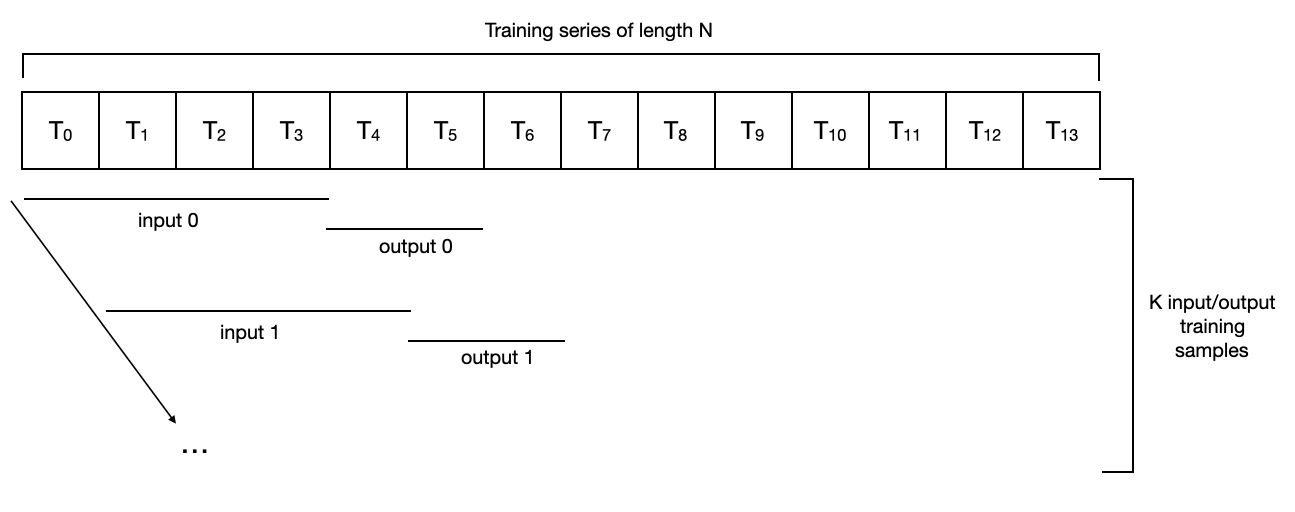
このようなデータセットでは、長さNの系列はN - input_chunk_length - output_chunk_length + 1のサンプル数の「トレーニングセット」になります。上記の例では、N=14、input_chunk_length=4、output_chunk_length=2 なので、学習に使うサンプル数は K = 9 となります。この場合，1つのトレーニングエポックは，すべてのサンプルに対する完全なパス（いくつかのミニバッチから構成される可能性があります）で構成されます．

モデルによって、デフォルトで使用するデータセットが異なることに注意してください。例えば、darts.utils.data.HorizonBasedDatasetはN-BEATS論文から着想を得ており、系列の終わりに「近い」サンプルを生成し、系列の始まりさえ無視する可能性があります。

TimeSeriesインスタンスから生成されるトレーニングサンプルを制御する必要がある場合、抽象的なdarts.utils.data.TrainingDatasetクラスを継承して、独自のトレーニングデータセットを実装することが可能です。Dartsデータセットはtorch Datasetを継承しているので、一度にすべてのデータをメモリにロードしない遅延バージョンを簡単に実装することができます。データセットの自分自身のインスタンスができたら、すべてのグローバル予測モデルでサポートされているfit_from_dataset()メソッドを直接呼び出すことができます。

複数の時系列に対するモデルの学習
このような機械はすべて、複数の時系列に対してシームレスに使用することができます。以下は、input_chunk_length=4、output_chunk_length=2の逐次データセットが、長さNとMの2つの系列に対してどのように見えるかを示しています。

![](https://github.com/arumajirou/-daily-test/blob/main/static/images/seq_dataset_multi_ts.png?raw=1)
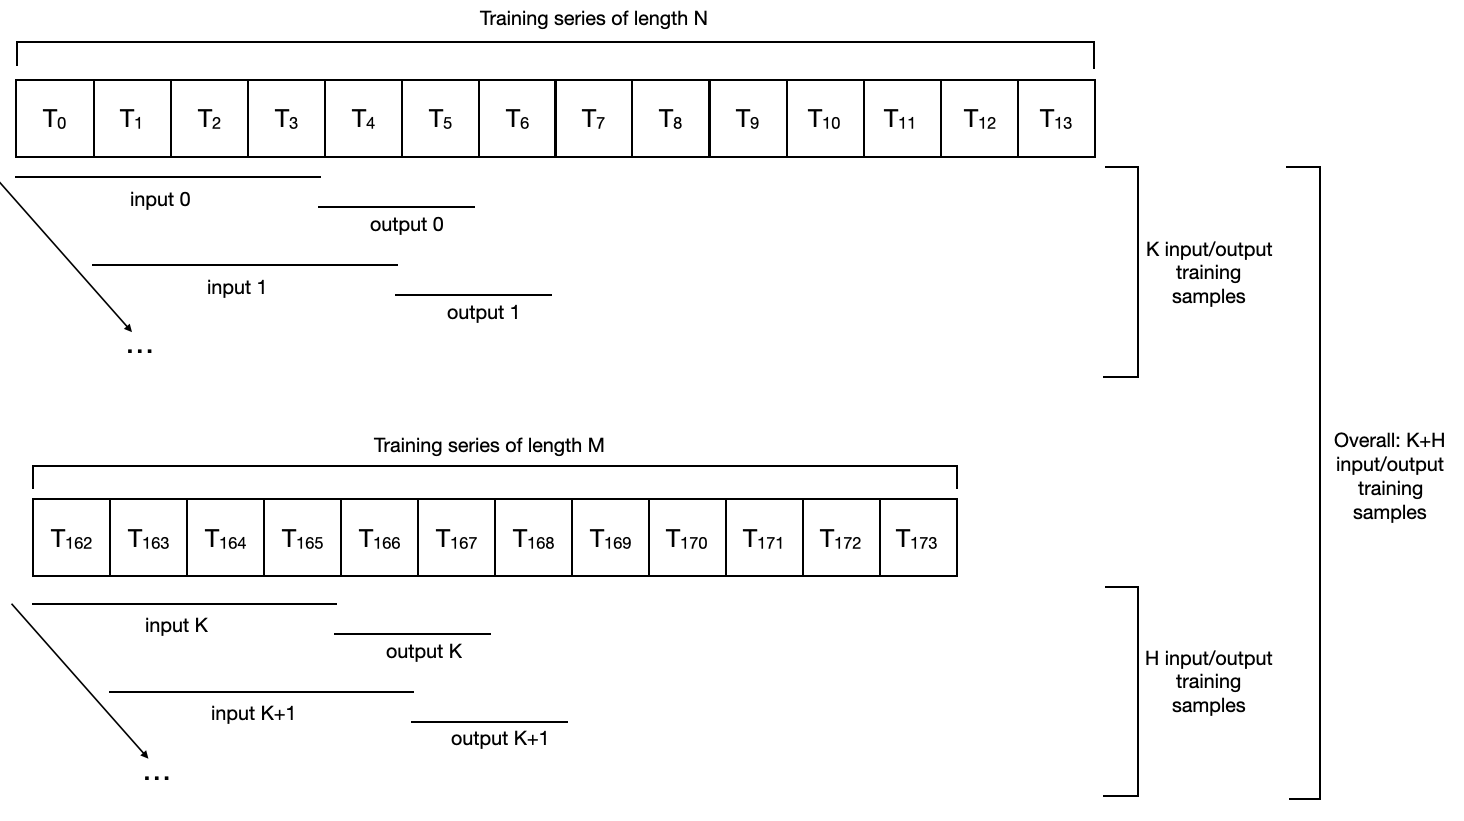


ここで少し注意することがあります。

異なるシリーズは同じ長さである必要はなく、同じタイムスタンプを共有する必要もありません。
実際、同じ周波数である必要もない。
トレーニングデータセットのサンプル数は、各シリーズに含まれるすべてのトレーニングサンプルの合計となります。
航空路と牛乳のシリーズを使った学習
2つの時系列（航空旅客と牛乳生産）に対して、別のモデルインスタンスを適合させる例を見てみましょう。ほぼ）同じ長さの2つの系列を使用すると、学習データセットサイズが（ほぼ）2倍になるので、エポック数は半分になります。








In [ ]:
#NBEATSModelはいくつかの初期化パラメータで定義されたクラス
#、モデルが学習する際、あるいは予測に使用する際の入力と出力のシーケンスの長さをそれぞれ指定します。
model_air_milk = NBEATSModel(
    input_chunk_length=24, 
    output_chunk_length=12, 
    n_epochs=100, #n_epochsパラメータは，学習エポック数（学習データセット全体を通過する数）を指定します
    #random_stateパラメータは，乱数生成器のシード値を指定します．
    #この値は，モデルの重みが学習のたびに同じように初期化されることを保証するために使用されます．
    random_state=0

)

Then, fitting the model on two (or more) series is as simple as giving a list of series (instead of a single series) in argument to the `fit()` function:

In [ ]:
model_air_milk.fit([train_air, train_milk], verbose=True);

Training: 0it [00:00, ?it/s]

### Producing Forecasts After the End of a Series


日本語


さて、重要なことは、予測を計算するときに、どの時系列について将来を予測したいかを指定することです。

以前はこの制約がありませんでした。1つの系列のみでモデルをフィットさせる場合、モデルはこの系列を内部的に記憶し、もしpredict()がseries引数なしで呼ばれると、（一意の）学習系列に対する予測を返します。この場合、predict()のseries引数は必須となります。

そこで、航空交通の将来を予測したいとします。この場合、predict()関数に series=train_air を指定し、 train_air の後に来るものの予測を得たいことを示します。

DeepL.comで別の訳し方を確認する



上


In [ ]:
#モデル（model_air_milk）を使って、時系列データセット（train_air）に対して予測をしようとしている
#モデルの予測は、元の時系列データ（series_air_scaled）に対してプロットされ、
#予測誤差は両者の平均絶対誤差（MAPE）として出力されます。

#predict関数のn引数は、将来を予測する時間ステップの数を指定します。
#この場合、モデルは36の時間ステップの予測をするように要求されています。
pred = model_air_milk.predict(n=36, 
#series引数は、モデルが予測を行うための入力として使用する時系列データである。
                              series=train_air)

#series_air_scaledデータは「実際」のデータとしてプロットされ、
series_air_scaled.plot(label="actual")
#モデルの予測は「予測」としてプロットされる。
pred.plot(label="forecast")
plt.legend()
#最後に、mape関数を使って、元の時系列データとモデルの予測値との間のMAPEを計算しています。
print("MAPE = {:.2f}%".format(mape(series_air_scaled, pred)))

Predicting: 7it [00:00, ?it/s]

MAPE = 7.16%


ImportError: ignored

<Figure size 432x288 with 1 Axes>


日本語


待てよ、これは牛乳の生産量が航空交通量の予測に役立つということか？
まあ、このモデルでのこの特別な例では、（少なくともMAPE誤差の点では）そうであるように思われます。でも、考えてみれば、これはそれほどおかしなことではありません。航空交通は毎年の季節性と上昇トレンドによって大きく特徴づけられています。牛乳の系列もこの2つの特徴を示しており、この場合、モデルがそれらを捉えるのに役立っているのでしょう。

このことは予測モデルの事前トレーニングの可能性を示唆しています。つまり、一旦モデルをトレーニングして、後でトレーニングセットに含まれていない系列を予測するのに使うのです。このおもちゃのモデルを使えば、他のどの系列の将来値も、たとえ訓練中に見たことのない系列であっても、本当に予測することができるのです。例えば、ある任意の正弦波系列の将来を予測したいとします。

DeepL.comで別の訳し方を確認する



下


In [ ]:
#このコードはsine_timeseriesという関数を使って、
#頻度が「M」の時系列データを生成しているようです（おそらく毎月）
any_series = sine_timeseries(length=50, freq="M")
#次にmodel_air_milkというモデルを使って、入力時系列に基づいた次の36期間（おそらく月）の予測を行っています。
pred = model_air_milk.predict(n=36, series=any_series)
#最後に、入力時系列と予測を同じグラフにプロットし、2つの線を識別するための凡例を加える。
any_series.plot(label='"any series, really"')
pred.plot(label="forecast")
#プロットに凡例を追加
plt.legend();

Predicting: 7it [00:00, ?it/s]

ImportError: ignored

<Figure size 432x288 with 1 Axes>




この予測は良くないが（正弦波には年ごとの季節性もない）、イメージはつかめるだろう。

- fit()関数でサポートされているのと同様に、predict()関数の引数に系列のリストを与えることもできます。
- 例えば、次のようにすれば、航空交通と牛乳の両系列の予測を一度に得ることができます。




In [ ]:
#model_air_milkのpredictメソッドを使って、
#train_airとtrain_milkという2つの時系列の予測を生成し、
#その結果をプロットしようとしている

#predictメソッドには、予測する時間ステップ数(n)と、
#予測する時系列のリスト(series)が必要です。
#このメソッドは予測された時系列のリストを返します。
pred_list = model_air_milk.predict(n=36, series=[train_air, train_milk])

#forループを使って予測された時系列とそのラベルを反復し
for series, label in zip(pred_list, ["air passengers", "milk production"]):
#plotメソッドを使ってそれぞれの予測された時系列をプロットしています。
#plotのlabel引数は、プロットされる時系列のラベルを指定するために使用され、
    series.plot(label=f"forecast {label}")
#これは凡例に表示されます。
plt.legend()

Predicting: 7it [00:00, ?it/s]

ImportError: ignored

<Figure size 432x288 with 1 Axes>

返される2つの系列は、それぞれtrain_airとtrain_milkの終了後の予測に対応する。

# 共変量系列
今までは、対象系列の履歴のみを用いて将来を予測するモデルで勝負してきました。しかし、上記で説明したように、グローバルダーツのモデルは共変量時系列の使用もサポートしています。これは「外部データ」の時系列で、必ずしも予測に興味があるわけではないが、貴重な情報を含んでいる可能性があるので、やはりモデルの入力として与えたいものである。

# 共変量の構築
空気と牛乳の時系列で、共変量として年と月を使う簡単な例を見てみましょう。

In [ ]:
# build year and month series:
#一連のタイムスタンプから年と月の情報を抽出
#datetime_attribute_timeseries関数は、一連のタイムスタンプから指定された属性（「年」または「月」）を抽出している
air_year = datetime_attribute_timeseries(series_air_scaled, attribute="year")
air_month = datetime_attribute_timeseries(series_air_scaled, attribute="month")

milk_year = datetime_attribute_timeseries(series_milk_scaled, attribute="year")
milk_month = datetime_attribute_timeseries(series_milk_scaled, attribute="month")

# stack year and month to obtain series of 2 dimensions (year and month):
#それらを積み重ねて2次元の系列を作り
#stack関数は、新しい軸に沿って年と月のシリーズを連結し、2次元のシリーズを作成するために使用されています
air_covariates = air_year.stack(air_month)
milk_covariates = milk_year.stack(milk_month)

# scale them between 0 and 1:
#スケーラーを使って0と1の間でスケーリングし
scaler_dt_air = Scaler()
air_covariates = scaler_dt_air.fit_transform(air_covariates)

scaler_dt_milk = Scaler()
milk_covariates = scaler_dt_milk.fit_transform(milk_covariates)

# split in train/validation sets:
#得られた系列を訓練セットと検証セットに分割している
#最後に、スケーリングされた系列が訓練セットと検証セットに分割
air_train_covariates, air_val_covariates = air_covariates[:-36], air_covariates[-36:]
milk_train_covariates, milk_val_covariates = (
    milk_covariates[:-36],
    milk_covariates[-36:],
)

# plot the covariates:
#共変量がプロット
plt.figure()
air_covariates.plot()
plt.title("Air traffic covariates (year and month)")

plt.figure()
milk_covariates.plot()
plt.title("Milk production covariates (year and month)");

ImportError: ignored

<Figure size 432x288 with 1 Axes>

ImportError: ignored

<Figure size 432x288 with 1 Axes>

では、それぞれの対象系列（大気と牛乳）に対して、同じ時間軸を持ち、年と月を含む共変量系列を構築しました。

ここで共変量系列は多変量時系列であることに注意してください：それらは2つの次元（1次元は年、もう1次元は月）を含んでいます。

# 共変量によるトレーニング
この例をもう一度、今度は共変量付きで見てみましょう。ここでは、BlockRNNModel を構築します。

In [ ]:
model_pastcov = BlockRNNModel(
    model="LSTM",
    input_chunk_length=24,
    output_chunk_length=12,
    n_epochs=100,
    random_state=0,
)

さて、共変量を使ってモデルを学習するには、fit()関数にpast_covariates引数として共変量（対象系列に一致するリスト形式）を与えるだけでよいのです。この引数はpast_covariatesと名付けられ、モデルが予測を行うためにこれらの共変量の過去の値を使用することができることを思い出させてくれます。

In [ ]:
model_pastcov.fit(
    series=[train_air, train_milk],
    past_covariates=[air_train_covariates, milk_train_covariates],
    verbose=False,
);

この例では共変量が将来簡単にわかるので、RNNModelを定義し、future_covariateとしてそれを使って学習させることもできます。

In [ ]:
model_futcov = RNNModel(
    model="LSTM",
    hidden_dim=20,
    batch_size=8,
    n_epochs=100,
    random_state=0,
    training_length=36,
    input_chunk_length=24,
    force_reset=True,
)

model_futcov.fit(
    series=[train_air, train_milk],
    future_covariates=[air_train_covariates, milk_train_covariates],
    verbose=False,
);

# 共変量による予測
同様に、予測を得るには、BlockRNNModel の predict() 関数に past_covariates 引数を指定すればよいのです。

In [ ]:
pred_cov = model_pastcov.predict(n=36, series=train_air, past_covariates=air_covariates)

series_air_scaled.plot(label="actual")
pred_cov.plot(label="forecast")
plt.legend();

ImportError: ignored

<Figure size 432x288 with 1 Axes>

ここでは、モデルを学習させた output_chunk_length よりも大きな予測地平 n で predict() を呼び出していることに注意してください。これは、BlockRNNModelが過去の共変量を使用しても、この場合、これらの共変量は将来的にも知られているので、Dartsは将来のn個の時間ステップに対して自動回帰的に予測を計算することができるためです。

RNNModelの場合、predict()関数にfuture_covariatesを指定するだけで、同様のアプローチを使用することができます。

In [ ]:
pred_cov = model_futcov.predict(
    n=36, series=train_air, future_covariates=air_covariates
)

series_air_scaled.plot(label="actual")
pred_cov.plot(label="forecast")
plt.legend();

ImportError: ignored

<Figure size 432x288 with 1 Axes>

# 共変量によるバックテスト
共変量を使用してモデルをバックテストすることもできます。例えば、12ヶ月のホライズンで、空気系列の75%から開始して、ランニング精度を評価することに興味があるとします。

In [ ]:
backtest_pastcov = model_pastcov.historical_forecasts(
    series_air_scaled,
    past_covariates=air_covariates,
    start=0.6,
    forecast_horizon=12,
    stride=1,
    retrain=False,
)

print(
    "MAPE (BlockRNNModel with past covariates) = {:.2f}%".format(
        mape(series_air_scaled, backtest_pastcov)
    )
)

backtest_futcov = model_futcov.historical_forecasts(
    series_air_scaled,
    future_covariates=air_covariates,
    start=0.6,
    forecast_horizon=12,
    stride=1,
    retrain=False,
)

print(
    "MAPE (RNNModel with future covariates) = {:.2f}%".format(
        mape(series_air_scaled, backtest_futcov)
    )
)

MAPE (BlockRNNModel with past covariates) = 10.48%
MAPE (RNNModel with future covariates) = 15.21%


選択されたハイパーパラメータ（およびランダムシード）により、past_covariatesを用いたBlockRNNModel（MAPE=10.48%）はfuture_covariatesを用いたRNNModel（MAPE=15.21%）より優れているようです。これら2つのモデルで得られた予測についてより良いアイデアを持つために、それらを隣同士にプロットすることが可能です。


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
series_air_scaled.plot(label="actual", ax=axs[0])
backtest_pastcov.plot(label="forecast BlockRNN", ax=axs[0])
axs[0].legend()
series_air_scaled.plot(label="actual", ax=axs[1])
backtest_futcov.plot(label="forecast RNN", ax=axs[1], color="darkviolet")
axs[1].legend()
plt.show()

ImportError: ignored

<Figure size 1008x432 with 2 Axes>

# 過去の共変量、未来の共変量、その他の条件付けについてもう少しだけ。
現時点では、Dartsはそれ自体が時系列である共変量をサポートしています。これらの共変量はモデル入力として使用されますが、それ自体が予測の対象になることはありません。共変量は必ずしもターゲット系列と一致する必要はありません（例えば、同じ時刻に開始する必要はありません）。Dartsは、学習と推論の両方で、ターゲットと共変量を正しくスライスするために、TimeSeriesの時間軸の実際の時間値を使用します。もちろん、共変量はまだ十分なスパンを持つ必要があり、そうでなければDartsは文句を言うでしょう。

上記で説明したように、TCNModel, NBEATSModel, BlockRNNModel, TransformerModelは過去の共変量を使用します（future_covariatesを使用しようとすると、文句を言われます）。もし、これらの過去の共変量がたまたま将来も知られているならば、これらのモデルは自動回帰的にn > output_chunk_length（上記のBlockRNNModelのように）の予測を作成することもできます。

これに対して、RNNModelは未来の共変量を使用します（past_covariatesを指定しようとすると、文句を言われます）。つまり、このモデルによる予測では、予測時刻から（少なくとも）n時間ステップ先の未来の共変量が必要となる。

過去と未来の共変量（および、それらが異なるモデルによって消費される方法）は、重要ですが、自明なトピックではありません。

# 多変量時系列の学習と予測
さて、1つの変数だけを予測するのではなく、一度に複数の変数を予測したいと思います。1つのモデルを学習するために2つの異なる一変量データセットが使用された多変量学習とは対照的に、学習セットは、複数の変数（コンポーネントと呼ぶ）のオブザベーションを含む1つの系列で構成されます。これらのコンポーネントは，通常，同じ性質（同じメトリックの測定）を示すが，これは必ずしもそうではない．

この例で取り上げていない場合でも、フィットメソッドに一連の多変量時系列を与えることで、複数の多変量時系列を使ってモデルを学習することもできます（もちろん、モデルが多変量時系列をサポートしていることが条件ですが）。

この例を説明するために、ElectricityDataset (Dartsでも利用可能)を使用します。このデータセットには、370のクライアントの電力消費量(kW)の測定値が含まれており、サンプリングレートは15分です。

DeepL.comで別の訳し方を確認する



下


In [ ]:
multi_serie_elec = ElectricityDataset().load()


この多変量系列は特に大きいので（370成分、140'256値）、1時間の頻度で系列を再サンプリングする前に3成分だけを保持することにする。最後に、学習期間を短縮するために、最後の168個の値（1週間）を保持する。


In [ ]:
# retaining only three components in different ranges
retained_components = ["MT_002", "MT_008", "MT_009"]
multi_serie_elec = multi_serie_elec[retained_components]
# resampling the multivariate time serie
multi_serie_elec = multi_serie_elec.resample(freq="1H")
# keep the values for the last 5 days
multi_serie_elec = multi_serie_elec[-168:]

In [ ]:
multi_serie_elec.plot()
plt.show()

ImportError: ignored

<Figure size 432x288 with 1 Axes>

# データ準備と推論ルーチン
データセットをトレーニングセット（6日）とバリデーションセット（1日）に分割し、値を正規化します。Dartsでは、すべてのモデルはfitを呼び出して学習し、predictを使って推論します。

In [ ]:
# split in train/validation sets
training_set, validation_set = multi_serie_elec[:-24], multi_serie_elec[-24:]

# define a scaler, by default, normalize each component between 0 and 1
scaler_dataset = Scaler()
# scaler is fit on training set only to avoid leakage
training_scaled = scaler_dataset.fit_transform(training_set)
validation_scaled = scaler_dataset.transform(validation_set)


def fit_and_pred(model, training, validation):
    model.fit(training)
    forecast = model.predict(len(validation))
    return forecast

ここで、上記で定義した関数を用いて、VARIMAモデルとRNNModelを1つずつ定義し、学習させます。データセットがInteger-indexなので、VARIMAモデルのトレンド引数はNoneに設定する必要がありますが、上のプロットではトレンドが見られないので、特に問題はありません。

In [ ]:
model_VARIMA = VARIMA(p=12, d=0, q=0, trend="n")

model_GRU = RNNModel(
    input_chunk_length=24,
    model="LSTM",
    hidden_dim=25,
    n_rnn_layers=3,
    training_length=36,
    n_epochs=200,
)

# training and prediction with the VARIMA model
forecast_VARIMA = fit_and_pred(model_VARIMA, training_scaled, validation_scaled)
print("MAE (VARIMA) = {:.2f}".format(mae(validation_scaled, forecast_VARIMA)))

# training and prediction with the RNN model
forecast_RNN = fit_and_pred(model_GRU, training_scaled, validation_scaled)
print("MAE (RNN) = {:.2f}".format(mae(validation_scaled, forecast_RNN)))

MAE (VARIMA) = 0.11


Training: 0it [00:00, ?it/s]

Predicting: 4it [00:00, ?it/s]

MAE (RNN) = 0.10


スケーラーを使って多変量解析の各要素を正規化したので、予測値を適切に視覚化するために、スケールを戻すことを忘れてはならない。

In [ ]:
forecast_VARIMA = scaler_dataset.inverse_transform(forecast_VARIMA)
forecast_RNN = scaler_dataset.inverse_transform(forecast_RNN)

labels = [f"forecast {component}" for component in retained_components]
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
validation_set.plot(ax=axs[0])
forecast_VARIMA.plot(label=labels, ax=axs[0])
axs[0].set_ylim(0, 500)
axs[0].set_title("VARIMA model forecast")
axs[0].legend(loc="upper left")
validation_set.plot(ax=axs[1])
forecast_RNN.plot(label=labels, ax=axs[1])
axs[1].set_ylim(0, 500)
axs[1].set_title("RNN model forecast")
axs[1].legend(loc="upper left")
plt.show()

TypeError: ignored

ImportError: ignored

<Figure size 1008x432 with 2 Axes>


日本語


正確さよりもスピードを優先したパラメータ選択のため、予測の質はあまりよくありません。元のデータセットからより多くの成分を使用するか、トレーニングセットのサイズを大きくすれば、両モデルの精度は改善されるはずです。また、VARIMAモデルでp（タイムラグ）を12ではなく24に設定することでデータセットの日ごとの季節性を考慮し、再トレーニングを行うことも改善の可能性があります。

# 多変量系列を用いた学習に関するコメント
一変量時系列で示した特徴、特に共変量（過去と未来）や連続した時系列の使用は、もちろん多変量時系列にも対応します（ただ、使用するモデルが実際に対応しているかどうかは確認してください）。

さらに、多変量系列をサポートするモデルは、異なるアプローチを使用する場合があります。例えば、TFTModel は、関連する特徴を選択するために特別なモジュールを使用しますが、NBEATSModel は、系列の成分を一変量系列に平らにし、特徴間の相互作用を捉えるために完全に連結されたレイヤーに依存します。


